In [2]:
import numpy as np

import shutil
import os
import matplotlib.pyplot as plt
import scipy.io as io
import datetime
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader, random_split, Subset

import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

from PIL import Image
import piq

In [3]:
torch.cuda.set_device(3)
device = torch.device("cuda")
print(f"Using {device} device")

Using cuda device


In [4]:
img_size = 224

transform = transforms.Compose([
    transforms.Resize((img_size,img_size)), # resize the images to 224x24 pixels
    transforms.ToTensor() # convert the images to a PyTorch tensor
])

class fdataset(Dataset):
    def __init__(self, fmri_path, img_path, transform=transform):
        self.fmri_data = np.load(fmri_path)
        self.img_name_list = os.listdir(img_path)
        self.img_name_list.sort()
        self.transform = transform
    
    def __len__(self):
        return self.fmri_data.shape[0]
    
    def __getitem__(self, i):
        fea = self.fmri_data[i]
        img_name = os.path.join("/home/featurize/data/subj01/training_split/training_images", self.img_name_list[i])
        img = Image.open(img_name).convert('RGB')
        if self.transform:
            img = self.transform(img)
            # img = np.array(img)
            # img = torch.tensor(img)
            # img = img.float()
            # img = img.permute(2,0,1)
        
        return fea, img, img_name

In [5]:
seed = 42
torch.manual_seed(seed)

total_dataset = fdataset(fmri_path="./all_fmri_3059.npy",
                        img_path="/home/featurize/data/subj01/training_split/training_images")

# print(len(total_dataset))
train_size = int(0.7 * len(total_dataset))
valid_size = int(0.2 * len(total_dataset))
test_size = len(total_dataset) - train_size - valid_size

print(train_size, valid_size, test_size)

# 使用random_split随机划分数据集
train_dataset, valid_dataset, test_dataset = random_split(total_dataset, [train_size, valid_size, test_size])

subset_length = len(train_dataset) // 4
indices = range(subset_length)
train_dataset = Subset(train_dataset, indices)
subset_length_t = len(test_dataset) // 4
indices_t = range(subset_length_t)
test_dataset = Subset(test_dataset, indices_t)

# 创建DataLoader以批量加载数据
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=True, num_workers=12)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=12)

print(len(train_loader))
print(len(valid_loader))
print(len(test_loader))

for fea, img, img_name in train_loader:
    print(fea.shape, img.shape)
    # print(img)
    break

6888 1968 985
108
123
16
torch.Size([16, 3059]) torch.Size([16, 3, 224, 224])


In [6]:
class DenseDecoder(nn.Module):
    def __init__(self, ncell=3059):
        super(DenseDecoder, self).__init__()
        self.fc1 = nn.Linear(ncell, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 3 * img_size * img_size)
        # self.dense_out = nn.Sequential(
        #     nn.ReLU(),
        #     nn.Reshape((imgsize, imgsize, 1))
        # )

    def forward(self, x):
        b = x.shape[0]
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        # print(x.size())
        x = x.reshape([b,3,img_size,img_size])
        return x

In [7]:
class CAE(nn.Module):
    def __init__(self):
        super(CAE, self).__init__()
        self.conv1_1 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn1_1 = nn.BatchNorm2d(64)
        self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn1_2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2)

        self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn2_1 = nn.BatchNorm2d(128)
        self.conv2_2 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn2_2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2)

        self.conv3_1 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3_1 = nn.BatchNorm2d(256)
        self.conv3_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.bn3_2 = nn.BatchNorm2d(256)

        self.conv4_1 = nn.Conv2d(256, 512, 3, padding=1)
        self.bn4_1 = nn.BatchNorm2d(512)
        self.conv4_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.bn4_2 = nn.BatchNorm2d(512)

        self.conv5_1 = nn.Conv2d(512, 1024, 3, padding=1)
        self.bn5_1 = nn.BatchNorm2d(1024)
        self.conv5_2 = nn.Conv2d(1024, 1024, 3, padding=1)
        self.bn5_2 = nn.BatchNorm2d(1024)

        self.up6 = nn.Conv2d(1024, 512, 3, padding=1)
        self.conv6_1 = nn.Conv2d(1024, 512, 3, padding=1)
        self.bn6_1 = nn.BatchNorm2d(512)
        self.conv6_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.bn6_2 = nn.BatchNorm2d(512)

        self.up7 = nn.Conv2d(512, 256, 3, padding=1)
        self.conv7_1 = nn.Conv2d(512, 256, 3, padding=1)
        self.bn7_1 = nn.BatchNorm2d(256)
        self.conv7_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.bn7_2 = nn.BatchNorm2d(256)

        self.up8 = nn.Conv2d(256, 128, 3, padding=1)
        self.conv8_1 = nn.Conv2d(256, 128, 3, padding=1)
        self.bn8_1 = nn.BatchNorm2d(128)
        self.conv8_2 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn8_2 = nn.BatchNorm2d(128)

        self.up9 = nn.Conv2d(128, 64, 3, padding=1)
        self.conv9_1 = nn.Conv2d(128, 64, 3, padding=1)
        self.bn9_1 = nn.BatchNorm2d(64)
        self.conv9_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn9_2 = nn.BatchNorm2d(64)
        self.conv9_3 = nn.Conv2d(64, 3, 3, padding=1)
        self.bn9_3 = nn.BatchNorm2d(3)
        self.conv10 = nn.Conv2d(3, 3, 1)

    def forward(self, x):
        conv1 = self.conv1_1(x)
#         print(conv1.shape)
        conv1 = self.bn1_1(conv1)
        conv1 = F.relu(conv1)
        conv1 = self.conv1_2(conv1)
#         print(conv1.shape)
        conv1 = self.bn1_2(conv1)
        conv1 = F.relu(conv1)
        pool1 = self.pool1(conv1)
#         print(pool1.shape)

        conv2 = self.conv2_1(pool1)
#         print(conv2.shape)
        conv2 = self.bn2_1(conv2)
        conv2 = F.relu(conv2)
        conv2 = self.conv2_2(conv2)
#         print(conv2.shape)
        conv2 = self.bn2_2(conv2)
        conv2 = F.relu(conv2)
        pool2 = self.pool2(conv2)

        conv3 = self.conv3_1(pool2)
#         print(conv3.shape)
        conv3 = self.bn3_1(conv3)
        conv3 = F.relu(conv3)
        conv3 = self.conv3_2(conv3)
#         print(conv3.shape)
        conv3 = self.bn3_2(conv3)
        conv3 = F.relu(conv3)

        conv4 = self.conv4_1(conv3)
        conv4 = self.bn4_1(conv4)
        conv4 = F.relu(conv4)
        conv4 = self.conv4_2(conv4)
        conv4 = self.bn4_2(conv4)
        conv4 = F.relu(conv4)

        conv5 = self.conv5_1(conv4)
        conv5 = self.bn5_1(conv5)
        conv5 = F.relu(conv5)
        conv5 = self.conv5_2(conv5)
        conv5 = self.bn5_2(conv5)
        conv5 = F.relu(conv5)
#         print(conv5.shape)

        up6 = self.up6(conv5)
#         print(conv4.shape)
#         print(up6.shape)
        merge6 = torch.cat((conv4, up6), dim=1)
        conv6 = self.conv6_1(merge6)
        conv6 = self.bn6_1(conv6)
        conv6 = F.relu(conv6)
        conv6 = self.conv6_2(conv6)
        conv6 = self.bn6_2(conv6)
        conv6 = F.relu(conv6)

        up7 = self.up7(conv6)
        # print(conv3.shape,up7.shape)
        merge7 = torch.cat((conv3, up7), dim=1)
        conv7 = self.conv7_1(merge7)
        conv7 = self.bn7_1(conv7)
        conv7 = F.relu(conv7)
        conv7 = self.conv7_2(conv7)
        conv7 = self.bn7_2(conv7)
        conv7 = F.relu(conv7)

        up8 = self.up8(conv7)
        up8 = F.interpolate(up8, size=( 112, 112), mode='bilinear', align_corners=False)
        # print(conv2.shape,up8.shape)
        merge8 = torch.cat((conv2, up8), dim=1)
        conv8 = self.conv8_1(merge8)
        conv8 = self.bn8_1(conv8)
        conv8 = F.relu(conv8)
        conv8 = self.conv8_2(conv8)
        conv8 = self.bn8_2(conv8)
        conv8 = F.relu(conv8)

        up9 = self.up9(conv8)
        up9 = F.interpolate(up9, size=( 224, 224), mode='bilinear', align_corners=False)
        # print(conv1.shape,up9.shape)
        merge9 = torch.cat((conv1, up9), dim=1)
        conv9 = self.conv9_1(merge9)
        conv9 = self.bn9_1(conv9)
        conv9 = F.relu(conv9)
        conv9 = self.conv9_2(conv9)
        conv9 = self.bn9_2(conv9)
        conv9 = F.relu(conv9)
        conv9 = self.conv9_3(conv9)
        # print("s")
        conv9 = self.bn9_3(conv9)
        # print("e")
        conv9 = F.relu(conv9)
        conv10 = self.conv10(conv9)
        conv10 = F.sigmoid(conv10)

        return conv10


In [8]:
train_loss_list, vali_loss_list = [], []
train_ssim_list, vali_ssim_list = [], []

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader)
    train_loss = 0
    train_ssim = 0
    per = 0
    model.train()
    for batch, (img_rgb, y, img_name) in enumerate(dataloader):
        # X, y = X.to(device), y.to(device)
        img_rgb = img_rgb.to(device)
        y = y.to(device)

        # Compute prediction error
        pred = model(img_rgb)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_ssim += piq.ssim(pred, y, data_range=1.).item()
        
        per += 1
        percentage = per/len(train_loader)
        now = '='*int(percentage*50)+'>'
        left = '*'*int((1-percentage)*50)
        percen = format(percentage*100, '.2f')
        print("\r", now + left + '\t' + f"{percen}" + '%', end="", flush=True)
    epoch_loss = train_loss / size
    avg_ssim = train_ssim / size
    train_loss_list.append(epoch_loss)
    train_ssim_list.append(avg_ssim)
    print(f"\ntrain loss is: {epoch_loss:.4f}\t" + f"train ssim is:{avg_ssim:.4f}")

        # if batch % 100 == 0:
        #     loss, current = loss.item(), batch * len(img_rgb)
        #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test(dataloader, model, loss_fn, best_loss):
    size = len(dataloader)
    # num_batches = len(dataloader)
    model.eval()
    test_loss, test_ssim = 0, 0
    with torch.no_grad():
        for (img_rgb, y, img_name) in dataloader:
            img_rgb = img_rgb.to(device)
            y = y.to(device)

            pred = model(img_rgb)
            test_loss += loss_fn(pred, y).item()
            test_ssim += piq.ssim(pred, y, data_range=1.).item()
            # correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    test_ssim /= size
    vali_loss_list.append(test_loss)
    vali_ssim_list.append(test_ssim)
    print(f"\nvali loss is: {test_loss:.4f}\t" + f"vali ssim is:{test_ssim:.4f}")
    
    if test_loss < best_loss:
        best_loss = test_loss
        torch.save(model.state_dict(), "./3059_0.001/best_model.pth")
    
    return best_loss
    # correct /= size
    # print(f"Test Error: \n, Avg loss: {test_loss:>8f} \n")

In [9]:
class End2EndTrain(nn.Module):
    def __init__(self):
        super(End2EndTrain, self).__init__()
        self.dense_decoder = DenseDecoder()
        self.cae = CAE()

    def forward(self, x):
        x = self.dense_decoder(x)
        x = self.cae(x)
        return x

In [10]:
big_model = End2EndTrain().to(device)

loss_fn = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(big_model.parameters(), lr=0.01)

In [ ]:
import time
s = time.time()
best_loss = float("inf")
epochs = 350
for t in range(epochs):
    list_dic = {}
    print(f"Epoch {t+1}\n")
    train(train_loader, big_model, loss_fn, optimizer)

    # test(train_dl, big_model, loss_fn)
    best_loss = test(test_loader, big_model, loss_fn, best_loss)
    list_dic = {"train_loss_list":train_loss_list, "vali_loss_list":vali_loss_list,
               "train_ssim_list":train_ssim_list, "vali_ssim_list":vali_ssim_list}
    np.save("./3059_0.001/list_dic.npy", list_dic)
e = time.time()
print(f"Done!, costs {e-s}s.")

Epoch 1

 ==================================================>	100.00%
train loss is: 0.0728	train ssim is:0.3572

vali loss is: 0.0728	vali ssim is:0.3610
Epoch 2

 ==================================================>	100.00%
train loss is: 0.0676	train ssim is:0.3589

vali loss is: 0.0657	vali ssim is:0.3652
Epoch 3

 ==================================================>	100.00%
train loss is: 0.0604	train ssim is:0.3613

vali loss is: 0.0688	vali ssim is:0.3598
Epoch 4

 ==================================================>	100.00%
train loss is: 0.0538	train ssim is:0.3686

vali loss is: 0.0632	vali ssim is:0.3652
Epoch 5

 ==================================================>	100.00%
train loss is: 0.0499	train ssim is:0.3705

vali loss is: 0.0654	vali ssim is:0.3614
Epoch 6

 ==================================================>	100.00%
train loss is: 0.0467	train ssim is:0.3738

vali loss is: 0.0684	vali ssim is:0.3609
Epoch 7

 ==================================================>	100.00%


In [14]:
one = iter(train_loader)
one = next(one)
print(one[0].shape, one[1].shape, one[2])

torch.Size([16, 1732]) torch.Size([16, 3, 224, 224]) ('/home/featurize/data/subj01/training_split/training_images/train-4388_nsd-32937.png', '/home/featurize/data/subj01/training_split/training_images/train-7955_nsd-59149.png', '/home/featurize/data/subj01/training_split/training_images/train-0535_nsd-04337.png', '/home/featurize/data/subj01/training_split/training_images/train-4080_nsd-30740.png', '/home/featurize/data/subj01/training_split/training_images/train-0821_nsd-06431.png', '/home/featurize/data/subj01/training_split/training_images/train-1801_nsd-13873.png', '/home/featurize/data/subj01/training_split/training_images/train-6055_nsd-44975.png', '/home/featurize/data/subj01/training_split/training_images/train-2153_nsd-16655.png', '/home/featurize/data/subj01/training_split/training_images/train-4684_nsd-34991.png', '/home/featurize/data/subj01/training_split/training_images/train-3642_nsd-27582.png', '/home/featurize/data/subj01/training_split/training_images/train-3840_nsd-2

In [15]:
test_fea = one[0].to(device)
pred_one = big_model(test_fea)
print(pred_one.shape)

torch.Size([16, 3, 224, 224])


In [16]:
pred_one = pred_one[4]
print(pred_one.shape)

torch.Size([3, 224, 224])


In [41]:
# mean = [0.485, 0.456, 0.406]
# std = [0.229, 0.224, 0.225]
# pred_one = pred_one.cpu() * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)

In [17]:
pred_one = pred_one.cpu().detach().numpy()
print(type(pred_one), pred_one.shape)

<class 'numpy.ndarray'> (3, 224, 224)


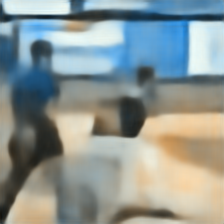

[[[127 148 156]
  [135 161 174]
  [153 183 199]
  ...
  [101 149 182]
  [107 150 179]
  [113 146 165]]

 [[121 144 155]
  [131 157 169]
  [155 184 198]
  ...
  [ 95 148 186]
  [101 149 183]
  [109 148 174]]

 [[107 132 146]
  [118 147 163]
  [150 181 197]
  ...
  [ 93 149 191]
  [100 153 190]
  [108 154 185]]

 ...

 [[ 43  45  41]
  [ 42  45  42]
  [ 53  55  51]
  ...
  [198 184 158]
  [199 185 159]
  [198 185 160]]

 [[ 46  49  46]
  [ 40  47  48]
  [ 54  61  60]
  ...
  [195 184 162]
  [197 185 161]
  [194 186 166]]

 [[ 63  70  70]
  [ 53  61  62]
  [ 58  63  61]
  ...
  [197 183 157]
  [200 186 159]
  [184 174 153]]]


In [18]:
numpy_array = (pred_one * 255).astype(np.uint8)
image = Image.fromarray(numpy_array.transpose(1, 2, 0))  # 注意转置通道顺序

# 显示图像
image.show()
print(numpy_array.transpose(1, 2, 0))

[[[216 233 251]
  [218 235 253]
  [218 235 253]
  ...
  [192 214 228]
  [190 212 226]
  [196 215 230]]

 [[215 232 252]
  [215 232 250]
  [213 230 248]
  ...
  [185 208 222]
  [180 203 217]
  [186 208 222]]

 [[201 217 240]
  [205 222 242]
  [209 227 247]
  ...
  [178 204 217]
  [173 199 212]
  [178 201 215]]

 ...

 [[ 53  55  54]
  [ 54  56  53]
  [ 48  50  47]
  ...
  [252 253 254]
  [252 253 254]
  [252 253 255]]

 [[ 50  52  51]
  [ 52  54  51]
  [ 45  47  45]
  ...
  [249 250 252]
  [249 250 252]
  [249 250 252]]

 [[ 47  49  48]
  [ 51  53  50]
  [ 44  46  43]
  ...
  [248 249 251]
  [248 249 251]
  [249 250 252]]]


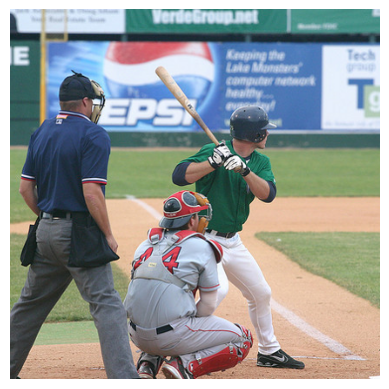

In [19]:
test_img_name = one[2][4]
test_img = Image.open(test_img_name).convert('RGB')
plt.figure()
plt.axis('off')
plt.imshow(test_img)
img_ar = np.array(test_img)
print(img_ar)

In [21]:
torch.save(big_model.state_dict(), './big_model.pth')